In [129]:
import os
import sys
import warnings
from typing import List
import copy

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
from statsmodels.nonparametric.smoothers_lowess import lowess
# from patsy import dmatrices
from stargazer.stargazer import Stargazer
#from utils.utils import lspline

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

In [130]:
path = os.path.join('data', 'morg-2014-emp.csv') # this will produce a path with the right syntax for your operating system
path


'data/morg-2014-emp.csv'

In [148]:
df = pd.read_csv(path, index_col = 0)
df.head()
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149316 entries, 3 to 317056
Data columns (total 22 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   hhid      149316 non-null  int64  
 1   intmonth  149316 non-null  object 
 2   stfips    149316 non-null  object 
 3   weight    149316 non-null  float64
 4   earnwke   149316 non-null  float64
 5   uhours    149316 non-null  int64  
 6   grade92   149316 non-null  int64  
 7   race      149316 non-null  int64  
 8   ethnic    20071 non-null   float64
 9   age       149316 non-null  int64  
 10  sex       149316 non-null  int64  
 11  marital   149316 non-null  int64  
 12  ownchild  149316 non-null  int64  
 13  chldpres  149316 non-null  int64  
 14  prcitshp  149316 non-null  object 
 15  state     149316 non-null  object 
 16  ind02     149316 non-null  object 
 17  occ2012   149316 non-null  int64  
 18  class     149316 non-null  object 
 19  unionmme  149316 non-null  object 
 20  unioncov 

In [154]:
# Filtering for teaching occupations 
selected_occupation_codes = [2200, 2300, 2310, 2320, 2330, 2340, 2540]
df = df[df['occ2012'].isin(selected_occupation_codes)]

#feature engineering
df["w"] = df["earnwke"] / df["uhours"]
df["lnw"] = np.log(df["w"])

#filter for working hours and earnings per week
df = df.query("uhours >= 20 & earnwke > 0 & w > 0")

#create gender variable for plotting
df['gender'] = df.sex.map(lambda x: 'female' if x == 2 else 'male') 

# Sort the data by age
df.sort_values(by = 'age', inplace = True) 

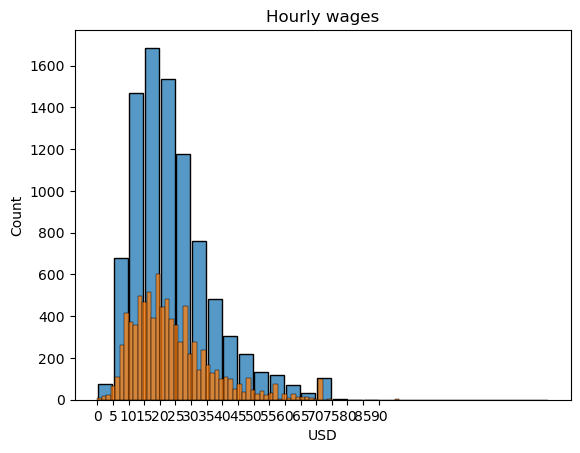

In [156]:
sns.histplot(df.w, shrink=0.9, bins = range(0,95,5))
plt.xticks(range(0,95,5))
plt.xlabel('USD')
plt.title('Hourly wages');

sns.histplot(df.w)
plt.xticks(range(0,95,5))
plt.xlabel('USD')
plt.title('Hourly wages');

#wage - log trabsformed 

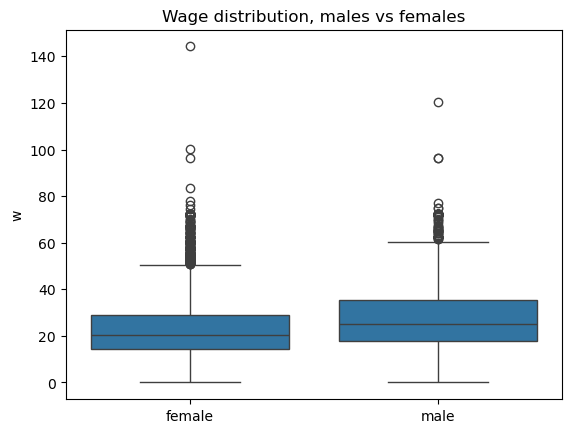

In [157]:
sns.boxplot(data = df, x = 'gender', y = 'w')
plt.xlabel(None)
plt.title('Wage distribution, males vs females');

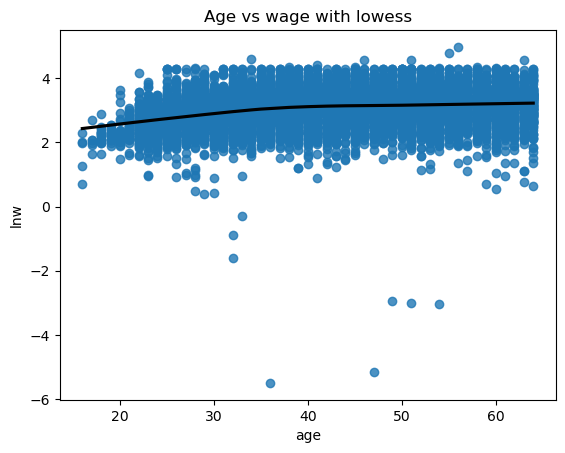

In [158]:
sns.regplot(
    data = df, x = 'age', y = 'lnw', 
    lowess = True, line_kws = {'color' : 'k'})
plt.title('Age vs wage with lowess');

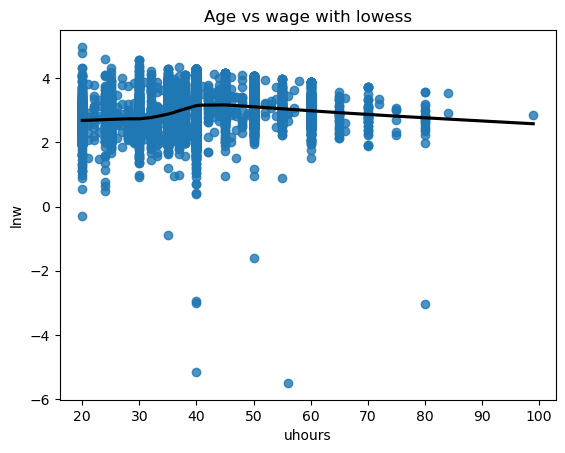

In [159]:
sns.regplot(
    data = df, x = 'uhours', y = 'lnw', 
    lowess = True, line_kws = {'color' : 'k'})
plt.title('Age vs wage with lowess');

In [160]:
# Square both age and uhours to see if there is a quadratic relationship
df['age_squared'] = df['age'] ** 2
df['uhours_squared'] = df['uhours'] ** 2

In [161]:
df.columns
df.gender.value_counts()

gender
female    6663
male      2203
Name: count, dtype: int64

In [162]:
#describtive stats 
df.loc[:, ["earnwke", "uhours", "w"]].describe().T

,count,mean,std,min,25%,50%,75%,max
earnwke,8866.0,978.946324,572.910399,0.230000,570.932500,884.610,1250.0,2884.6100
uhours,8866.0,40.128807,8.679614,20.000000,40.000000,40.000,40.0,99.0000
w,8866.0,24.146005,13.287039,0.004107,14.957111,21.625,30.0,144.2305


In [163]:
# Create binary variables
df['uni_binary'] = (df['grade92'] >= 43).astype(int)
df['hs_binary'] = df['grade92'].between(39, 42).astype(int)
df['no_hs_binary'] = (df['grade92']<= 38).astype(int)
df['race_white'] = (df['race'] == 1).astype(int)  
df['race_black'] = (df['race'] == 2).astype(int) 
df['race_asian'] = (df['race'] == 4).astype(int) 
df['race_other'] = (~df['race'].isin([1, 2, 4])).astype(int)
df['marital_binary'] = df['marital'].isin([1, 2, 3]).astype(int)
df['ownchild_binary'] = (df['ownchild'] > 0).astype(int)
df['class_private'] = df['class'].apply(lambda x: 1 if 'Private' in x else 0)
df['citizen_us'] = df['prcitshp'].apply(lambda x: 1 if 'Native' in x else 0)
df["female"] = (df.sex == 2).astype(int)

# Display the first few rows to verify
df.head()

,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,age,...,race_asian,race_other,marital_binary,ownchild_binary,class_private,citizen_us,female,w,lnw,gender
262839,510650169340085,October,WI,1443.6986,181.2,24,37,4,NaN,16,...,1,0,0,0,1,1,1,7.55,2.021548,female
161948,610009071839620,July,DE,641.9280,80.0,40,36,1,NaN,16,...,0,0,0,0,1,0,1,2.00,0.693147,female
256844,910005854409202,October,PA,2983.0704,70.0,20,37,1,NaN,16,...,0,0,0,0,1,1,1,3.50,1.252763,female
277197,50019501204721,November,MO,4359.5158,290.0,40,43,4,NaN,16,...,1,0,0,0,1,0,1,7.25,1.981001,female
167999,432789015909962,July,ME,575.6326,400.0,40,36,1,NaN,16,...,0,0,0,0,1,1,1,10.00,2.302585,female


In [196]:
df.columns

Index(['hhid', 'intmonth', 'stfips', 'weight', 'earnwke', 'uhours', 'grade92',
       'race', 'ethnic', 'age', 'sex', 'marital', 'ownchild', 'chldpres',
       'prcitshp', 'state', 'ind02', 'occ2012', 'class', 'unionmme',
       'unioncov', 'lfsr94', 'age_squared', 'uhours_squared', 'uni_binary',
       'hs_binary', 'no_hs_binary', 'race_white', 'race_black', 'race_asian',
       'race_other', 'marital_binary', 'ownchild_binary', 'class_private',
       'citizen_us', 'female', 'w', 'lnw', 'gender'],
      dtype='object')

In [199]:
import statsmodels.formula.api as smf

# Reg0: Log wage as a function of age and U hours
reg_0 = smf.ols(formula='lnw ~ age + uhours', data=df).fit(cov_type='HC0')

# Reg1: Adds squared terms for age and U hours
reg_1 = smf.ols(formula='lnw ~ age + uhours + age_squared + uhours_squared', data=df).fit(cov_type='HC0')

# Reg2: Includes gender and education
reg_2 = smf.ols(formula='lnw ~ age + uhours + age_squared + uhours_squared + female + race_white', data=df).fit(cov_type='HC0')

# Reg3: Includes everything (race, marital status, children, work type, citizenship)
reg_3 = smf.ols(formula='lnw ~ age + uhours + age_squared + uhours_squared + female + uni_binary + '
                        'hs_binary +  race_white + race_black + race_asian + marital_binary + '
                        'ownchild_binary + class_private + citizen_us', data=df).fit(cov_type='HC0')

# Reg3.1: Same as Reg3 but excludes high school and no high school (only university)
reg_3_1 = smf.ols(formula='lnw ~ age + uhours + age_squared + uhours_squared + female + uni_binary + '
                          'race_white + race_black + race_asian + marital_binary + '
                          'ownchild_binary + class_private + citizen_us', data=df).fit(cov_type='HC0')

# Reg4: Includes interaction terms
reg_4 = smf.ols(formula='lnw ~ age + uhours + age_squared + uhours_squared + female + uni_binary + '
                        'race_white + race_black + race_asian  + marital_binary + '
                        'ownchild_binary + class_private + citizen_us + '
                        'female:uhours + female:marital_binary', data=df).fit(cov_type='HC0')

from stargazer.stargazer import Stargazer

# Create Stargazer table
stargazer = Stargazer([reg_0, reg_1, reg_2, reg_3, reg_3_1, reg_4])
stargazer.title("Regression Results")
stargazer.custom_columns(['Reg0', 'Reg1', 'Reg2', 'Reg3', 'Reg3.1', 'Reg4'], [1, 1, 1, 1, 1, 1])

# Print HTML table (for Jupyter)
stargazer

# Alternatively, print LaTeX table (for reports)
# print(stargazer.render_latex())

to include : create binaries -> grade 92 (collage or no), race (white or not), marital, ownchild, class (private or gov),citizen of us or no,  gender 

numerical - age (experiance), hours per week, 

y - earn per week 


In [187]:
df.shape
print(df.uni_binary.value_counts())
print(df.hs_binary.value_counts())
print(df.no_hs_binary.value_counts())


uni_binary
1    7141
0    1725
Name: count, dtype: int64
hs_binary
0    7197
1    1669
Name: count, dtype: int64
no_hs_binary
0    8810
1      56
Name: count, dtype: int64


In [189]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['female', 'marital_binary', 'ownchild_binary', 'class_private', 'citizen_us', 'race_white', 'race_black', 'race_asian', 'race_other']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns
print(vif)

         VIF          Feature
0   1.004194           female
1   1.177847   marital_binary
2   1.142120  ownchild_binary
3   1.014041    class_private
4   1.254402       citizen_us
5  19.253833       race_white
6   2.602933       race_black
7   1.279306       race_asian
8   1.437636       race_other


In [190]:
df.race_white.value_counts()

race_white
1    7565
0    1301
Name: count, dtype: int64

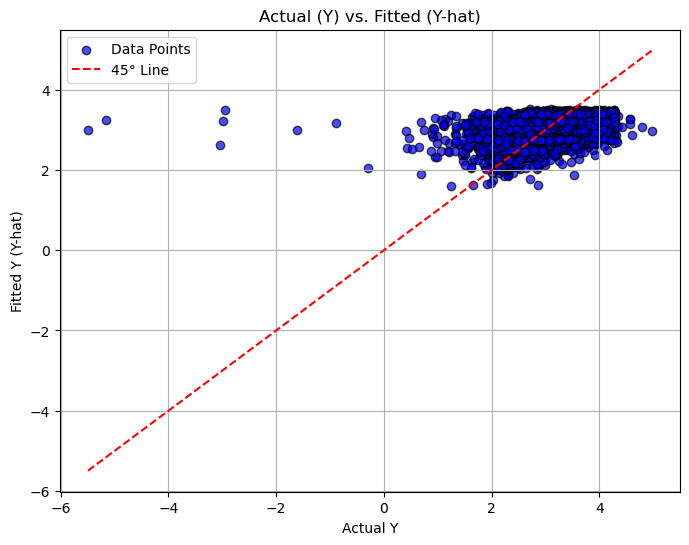

In [192]:
# - Points near the 45° line indicate good model performance.
# - Deviations highlight areas where the model under- or over-predicts.

# Actual values and fitted values from the model
y_actual = reg4.model.endog
y_fitted = reg4.fittedvalues

plt.figure(figsize=(8, 6))

# Scatter plot of actual vs fitted
plt.scatter(y_actual, y_fitted, alpha=0.7, color="blue", edgecolors="k", label="Data Points")

# 45° line for reference (where actual = fitted)
min_val = min(y_actual.min(), y_fitted.min())
max_val = max(y_actual.max(), y_fitted.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="45° Line")

# Plot formatting
plt.title("Actual (Y) vs. Fitted (Y-hat)")
plt.xlabel("Actual Y")
plt.ylabel("Fitted Y (Y-hat)")
plt.legend()
plt.grid(True)
plt.show()

In [201]:
import numpy as np
import pandas as pd

# List of models and their names
models = [reg_0, reg_1, reg_2, reg_3, reg_3_1, reg_4]
model_names = ['basic', 'squared terms', 'With Gender & Race', 'incl all edu', 'full model', 'with interactions']

# Initialize an empty list to store the results
results = []

# Calculate metrics for each model
for model, name in zip(models, model_names):
    # Calculate RMSE
    residuals = model.resid
    rmse = np.sqrt(np.mean(residuals**2))

    # Append model results to the list
    results.append({
        'Model': name,
        'R-squared': model.rsquared,
        'Adjusted R-squared': model.rsquared_adj,
        'AIC': model.aic,
        'BIC': model.bic,
        'RMSE': rmse
    })

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the comparison table
results_df

,Model,R-squared,Adjusted R-squared,AIC,BIC,RMSE
0,basic,0.064232,0.064021,14719.760098,14741.030035,0.554797
1,squared terms,0.109459,0.109057,14284.552599,14320.002494,0.541224
2,With Gender & Race,0.139964,0.139382,13979.530309,14029.160162,0.531874
3,incl all edu,0.235976,0.234768,12946.013792,13052.363477,0.501307
4,full model,0.234691,0.233567,12958.915163,13058.174870,0.501728
5,with interactions,0.235056,0.233760,12958.685235,13072.124900,0.501609


Discussion of Results

Model 4 was chosen as the best candidate for this analysis due to its balance of simplicity, interpretability, and strong performance across key metrics. Unlike Model 3, which includes a separate binary variable for high school education, Model 4 focuses solely on whether an individual has a university degree. This decision avoids potential instability caused by the small “no high school” group, which accounts for only ~50 observations out of 8,300, while still providing meaningful insights into the impact of education on wages.

When compared to the other models, Model 4 performs similarly to Model 3 in terms of adjusted R-squared (0.2336 vs. 0.2347) and RMSE (0.5017 vs. 0.5013), while slightly increasing AIC and BIC. However, it outperforms simpler models like Model 0, Model 1, and Model 2, all of which have lower R-squared values and higher RMSE. Compared to Model 5, which includes interaction terms, Model 4 achieves nearly identical metrics for adjusted R-squared (0.2336 vs. 0.2338) and RMSE (0.5017 vs. 0.5016), while having slightly better BIC (13058.17 vs. 13072.12). These similarities indicate that the additional complexity in Model 5 does not meaningfully enhance the model’s performance. By simplifying the education variable and avoiding potential overfitting, Model 4 stands out as the most reliable and interpretable model for this analysis. A train-test split and cross-validation will further validate its robustness and predictive accuracy.

In [202]:
## test - train split 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define dependent (y) and independent (X) variables for Model 4
y = df['lnw']  # Dependent variable: log(wage)
X = df[['age', 'uhours', 'age_squared', 'uhours_squared', 'female', 'uni_binary',
        'race_white', 'race_black', 'race_asian', 'marital_binary',
        'ownchild_binary', 'class_private', 'citizen_us']]  # Independent variables

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model on training data
import statsmodels.api as sm
X_train = sm.add_constant(X_train)  # Add intercept
model_4_train = sm.OLS(y_train, X_train).fit()

# Predict on test data
X_test = sm.add_constant(X_test)  # Add intercept to test data
y_pred = model_4_train.predict(X_test)

# Calculate RMSE on test data
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE for Model 4: {rmse_test:.4f}")

# Optional: Display summary of Model 4 (on training data)
print(model_4_train.summary())

Test RMSE for Model 4: 0.4601
                            OLS Regression Results                            
Dep. Variable:                    lnw   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     156.1
Date:                Thu, 16 Jan 2025   Prob (F-statistic):               0.00
Time:                        15:26:36   Log-Likelihood:                -5311.5
No. Observations:                7092   AIC:                         1.065e+04
Df Residuals:                    7078   BIC:                         1.075e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const       